In [1]:
import os
import pandas as pd
import scanpy as sc
import anndata as ad
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import font_manager as fm


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor="white")
sc.set_figure_params(fontsize=12)
sc.settings.vector_friendly = False

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==2.0.2 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


## Load Control and Drug Control Data

In [3]:
# h5ad Object was generated in the Control_analysis.ipynb Notebook
adata_combined=sc.read_h5ad('Final_Notebooks/Final_Objects/PBMC_Unprocessed.h5ad')

adata_combined = adata_combined[adata_combined.obs['Condition'].isin(['Control',
                                                     'BTP2',
                                                     'CM4620'])]
adata = adata_combined.copy()
adata

AnnData object with n_obs × n_vars = 68211 × 16537
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample'

### Visulaize QC metrics

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

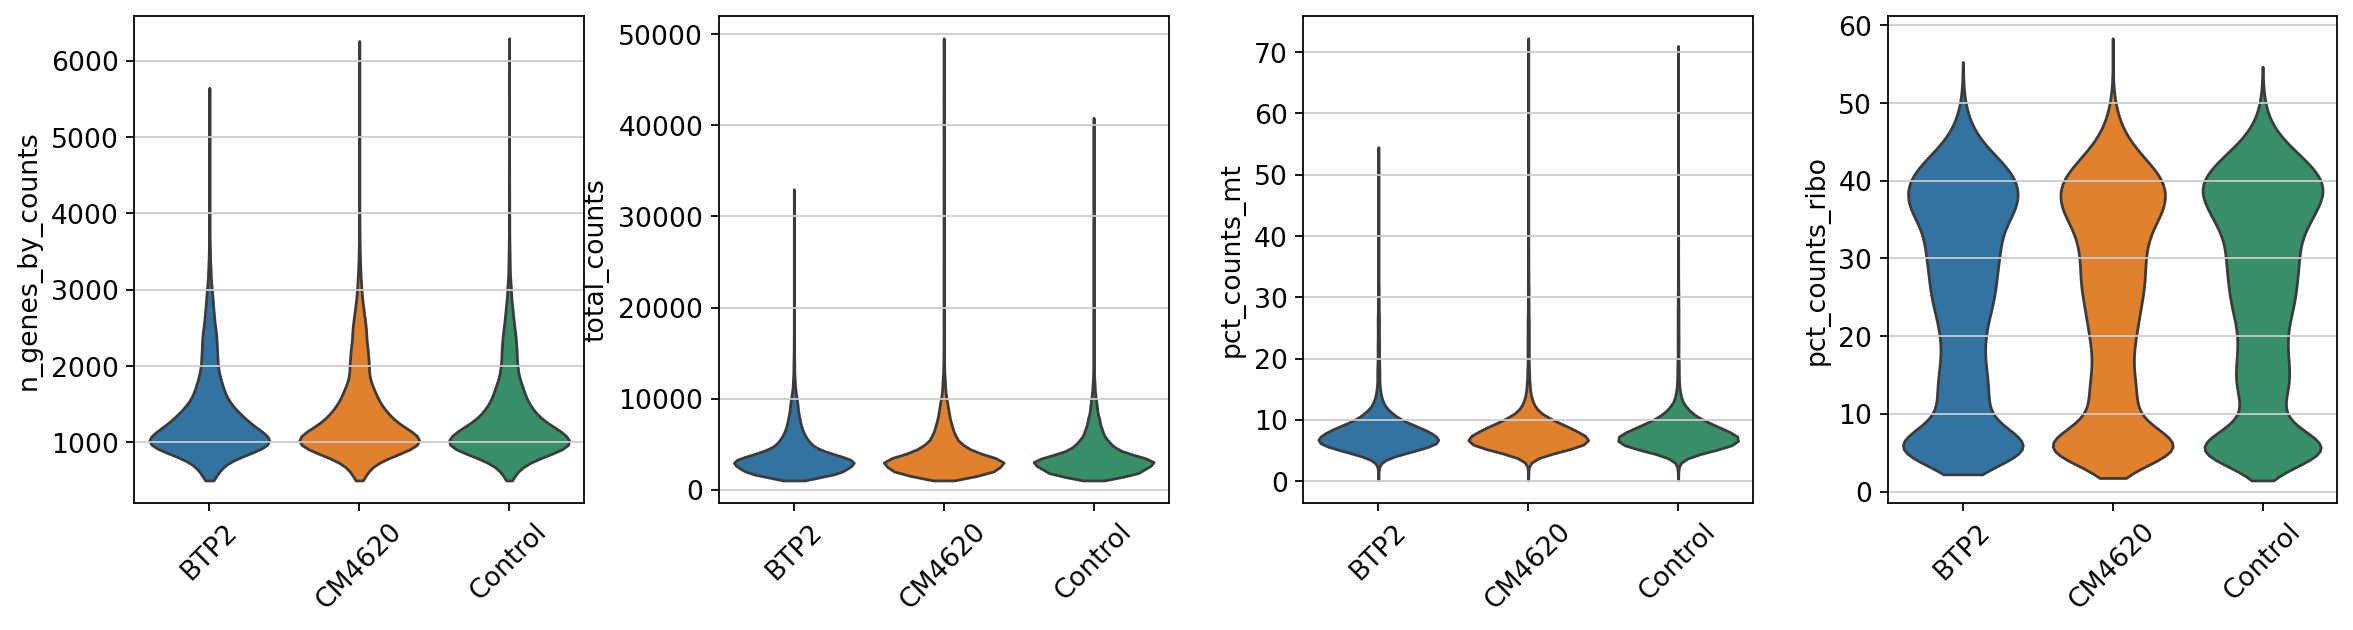

In [5]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt","pct_counts_ribo"],
    jitter=0.4,
    groupby = 'Condition',
    multi_panel=True,
    stripplot=False,rotation=45
)

In [6]:
adata.obs['predicted_doublet'].value_counts()

predicted_doublet
False    67586
True       625
Name: count, dtype: int64

In [7]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [8]:
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [9]:

adata.obs['predicted_doublet_0.2'] = adata.obs['doublet_score'] > 0.20
adata.obs['predicted_doublet_0.25'] = adata.obs['doublet_score'] > 0.25

In [10]:
adata.obs['predicted_doublet_0.2'].value_counts()

predicted_doublet_0.2
False    66108
True      2103
Name: count, dtype: int64

In [11]:
adata.obs['predicted_doublet_0.25'].value_counts()

predicted_doublet_0.25
False    66824
True      1387
Name: count, dtype: int64

/tmp/ipykernel_2978153/3436856488.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='predicted_doublet_0.2', y='doublet_score', data=adata.obs, palette="Set2")


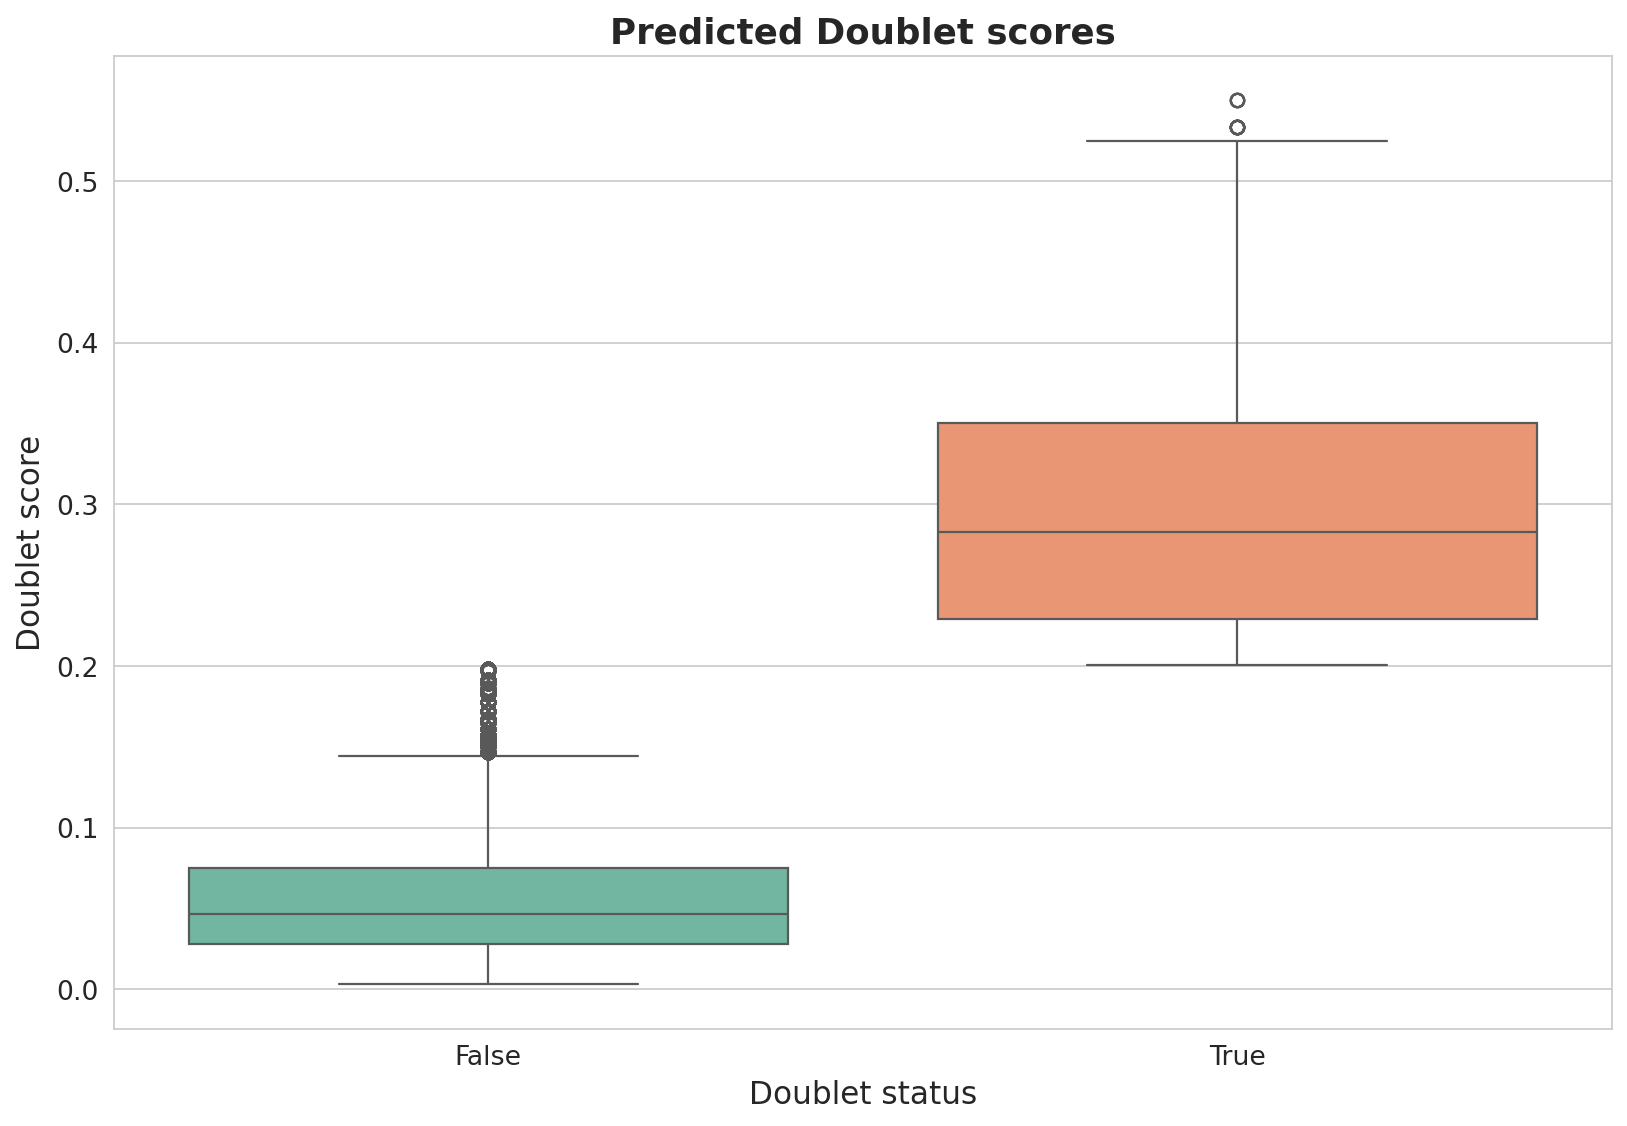

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))  # Larger figure size
sns.boxplot(x='predicted_doublet_0.2', y='doublet_score', data=adata.obs, palette="Set2")

# Adding labels and title
plt.title('Predicted Doublet scores', fontsize=16, fontweight='bold')
plt.xlabel('Doublet status', fontsize=14)
plt.ylabel('Doublet score', fontsize=14)

# Show the plot
plt.show()

In [13]:
#Filter Doublets
adata_filtered = adata[adata.obs['predicted_doublet_0.2']==False]
adata_filtered = adata_filtered[adata_filtered.obs['pct_counts_mt'] < 20.0]

### Cluster

extracting highly variable genes
    finished (0:00:02)


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 12
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:48)
running Leiden clustering


/tmp/ipykernel_2978153/318414970.py:35: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 17 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:14)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden_0.9', the cluster labels (adata.obs, categorical) (0:00:13)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:14)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden_1.1', the cluster labels (adata.obs, categorical) (0:00:20)


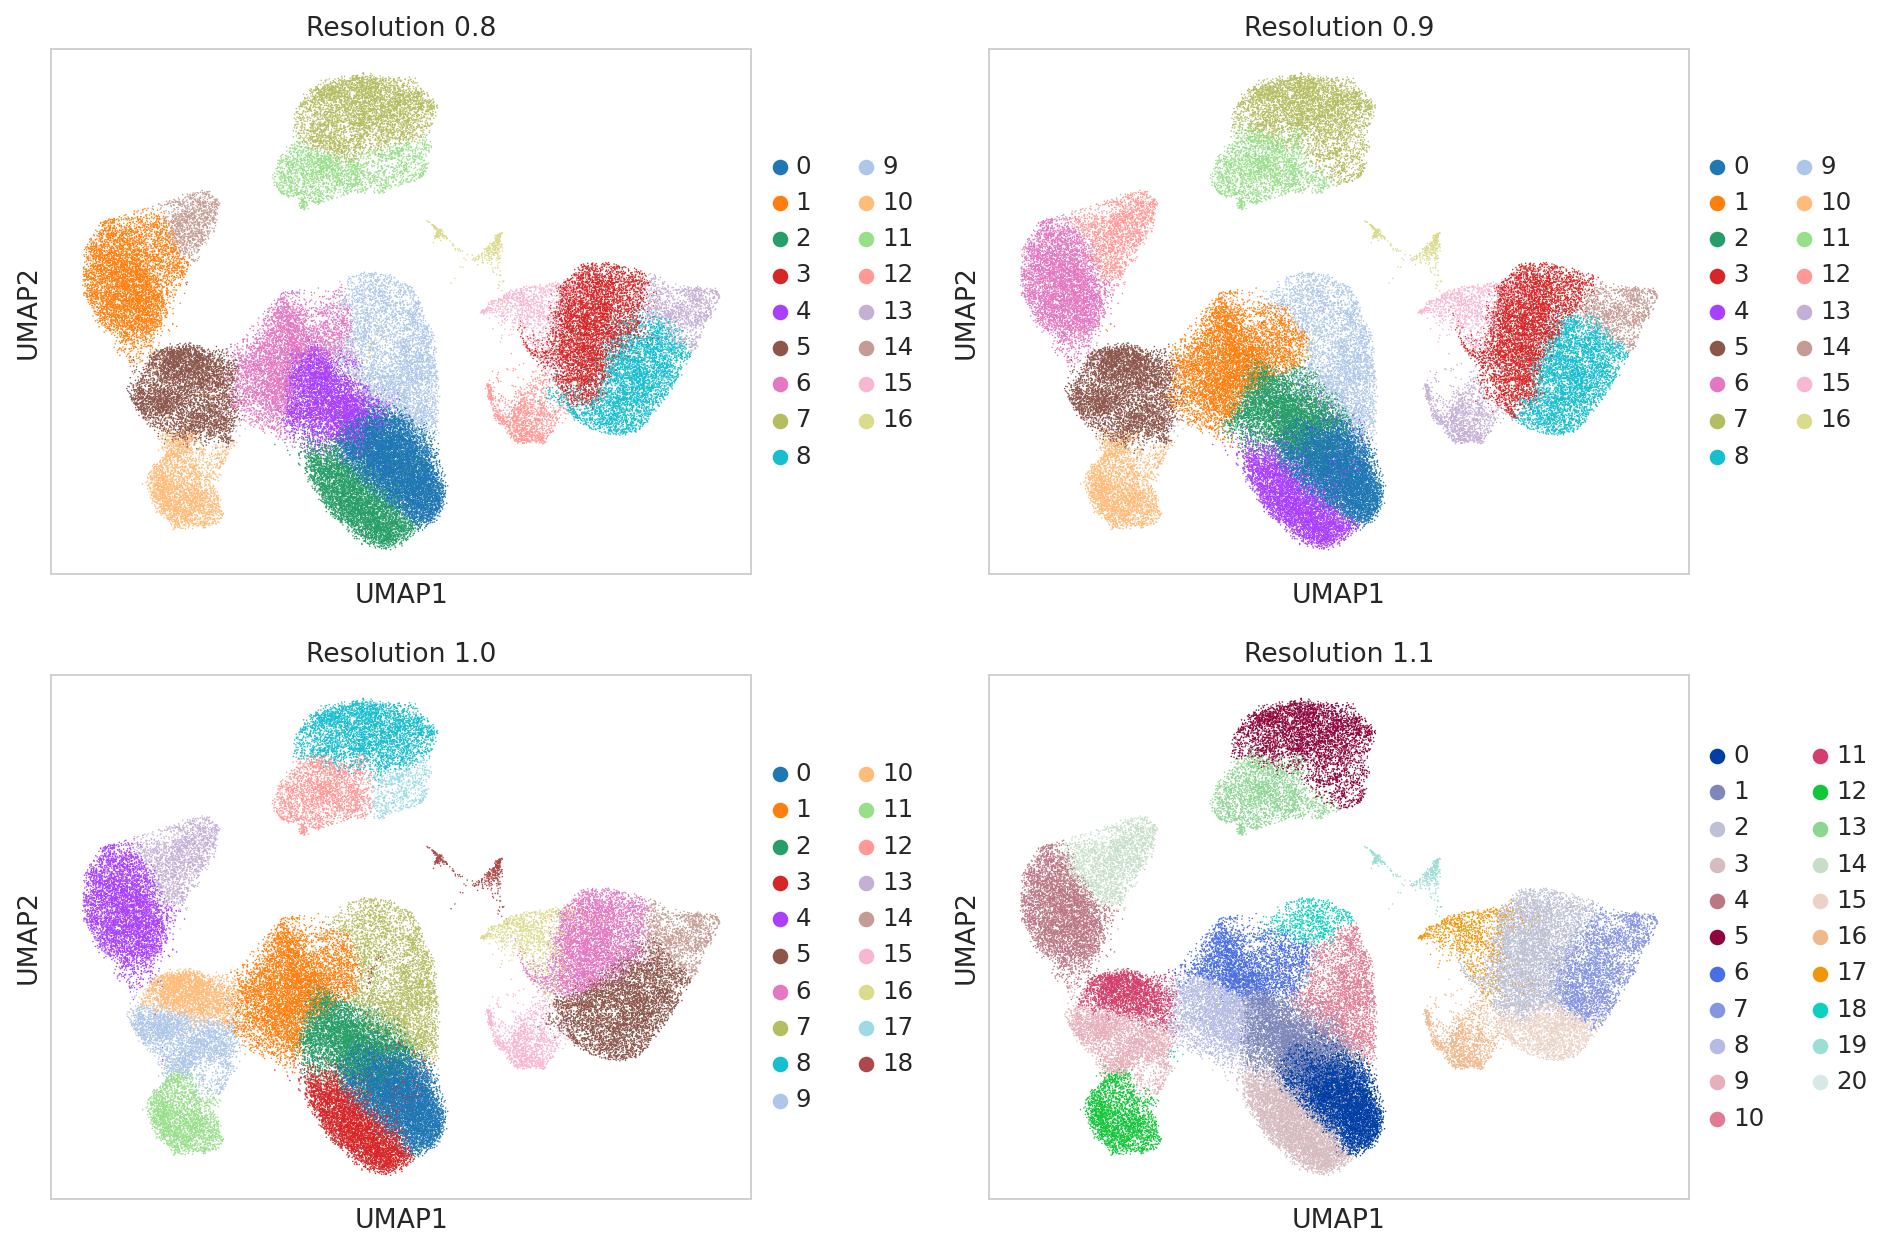

In [15]:
# Convert the raw (log-normalized) data from a filtered AnnData object to a full AnnData object
# This is often used after subsetting to ensure clean preprocessing
adata_new = adata_filtered

# Ensure log1p base is None (natural log), which is the default used in Scanpy
adata_new.uns["log1p"]["base"] = None

# Identify highly variable genes across samples
sc.pp.highly_variable_genes(adata_new, batch_key="sample")

# Store a copy of the raw data before subsetting (preserves all genes and normalized counts)
adata_new.raw = adata_new

# Subset to only highly variable genes
adata_new = adata_new[:, adata_new.var.highly_variable]

# Scale data: center to 0 mean and unit variance, with a clipping max of 10
sc.pp.scale(adata_new, max_value=10)

# Perform PCA to reduce dimensionality, using arpack (robust for sparse matrices)
sc.tl.pca(adata_new, svd_solver="arpack")

# Compute neighborhood graph using the first 12 PCs
sc.pp.neighbors(adata_new, n_pcs=12)

# Embed the cells in 2D space using UMAP
sc.tl.umap(adata_new)

# Define a list of Leiden clustering resolutions to explore
resolutions = np.arange(0.8, 1.2, 0.1)  # From 0.8 to 1.1 (inclusive), stepping by 0.1

# Run Leiden clustering for each resolution and store results under a unique key
for resolution in resolutions:
    key_added = f'leiden_{resolution:.1f}'
    sc.tl.leiden(
        adata_new,
        resolution=resolution,
        random_state=0,  # Ensures reproducibility
        key_added=key_added
    )

# Set up a 2x2 subplot layout for UMAPs colored by Leiden clusters at different resolutions
n_rows = 2
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8))
axs = axs.flatten()

# Plot UMAPs for the first four resolutions
# If more than 4 resolutions, adjust subplot grid accordingly
for i, resolution in enumerate(resolutions[:len(axs)]):
    key_added = f'leiden_{resolution:.1f}'
    sc.pl.umap(
        adata_new,
        color=[key_added],
        title=f'Resolution {resolution:.1f}',
        ax=axs[i],
        show=False
    )

# Optimize spacing between plots
plt.tight_layout()

# Show all subplots
plt.show()


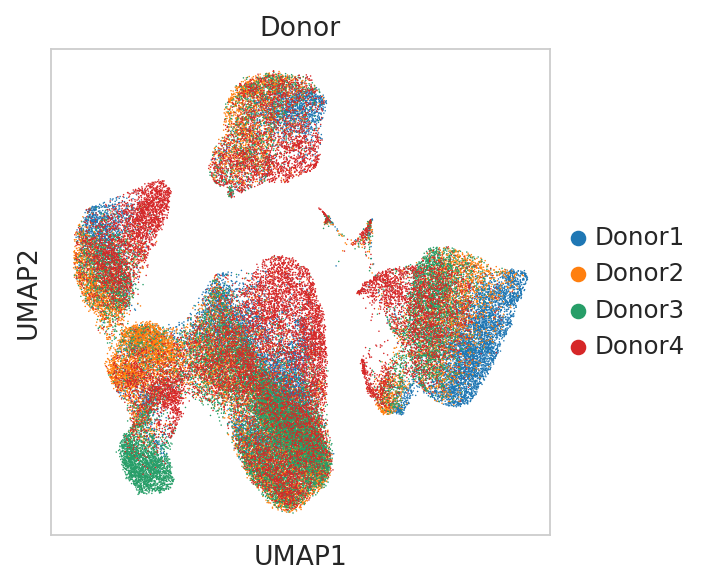

In [16]:
sc.pl.umap(adata_new, color=["Donor"])

In [17]:
# Order Conditions
manual_order = ['Control', 
                'BTP2', 
                'CM4620']  

adata_new.obs['Condition'] = pd.Categorical(adata_new.obs['Condition'], categories=manual_order, ordered=True)


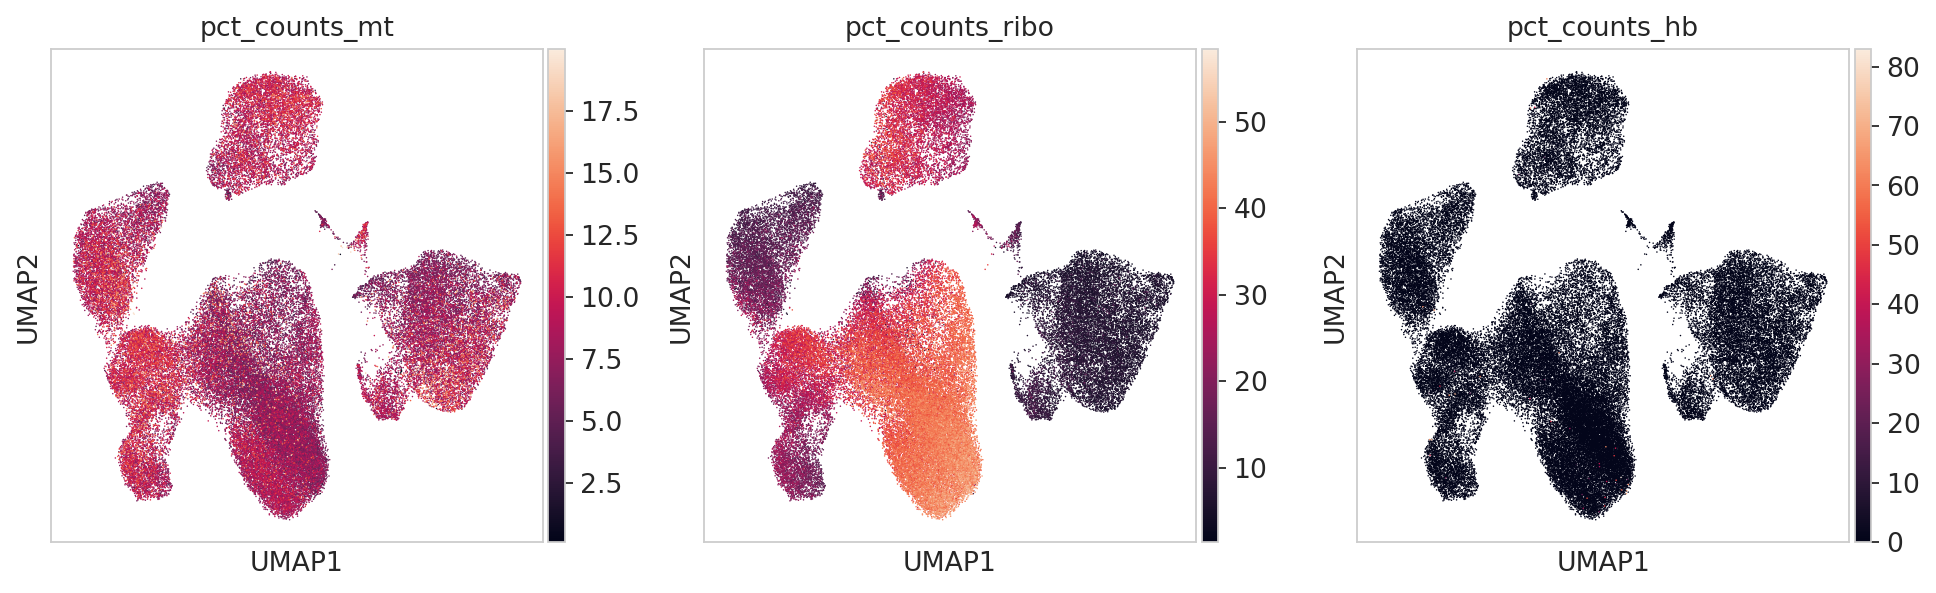

In [18]:

sc.pl.umap(adata_new, color=["pct_counts_mt","pct_counts_ribo","pct_counts_hb"])

ranking genes
    finished: added to `.uns['groups_genes_leiden_1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:38)


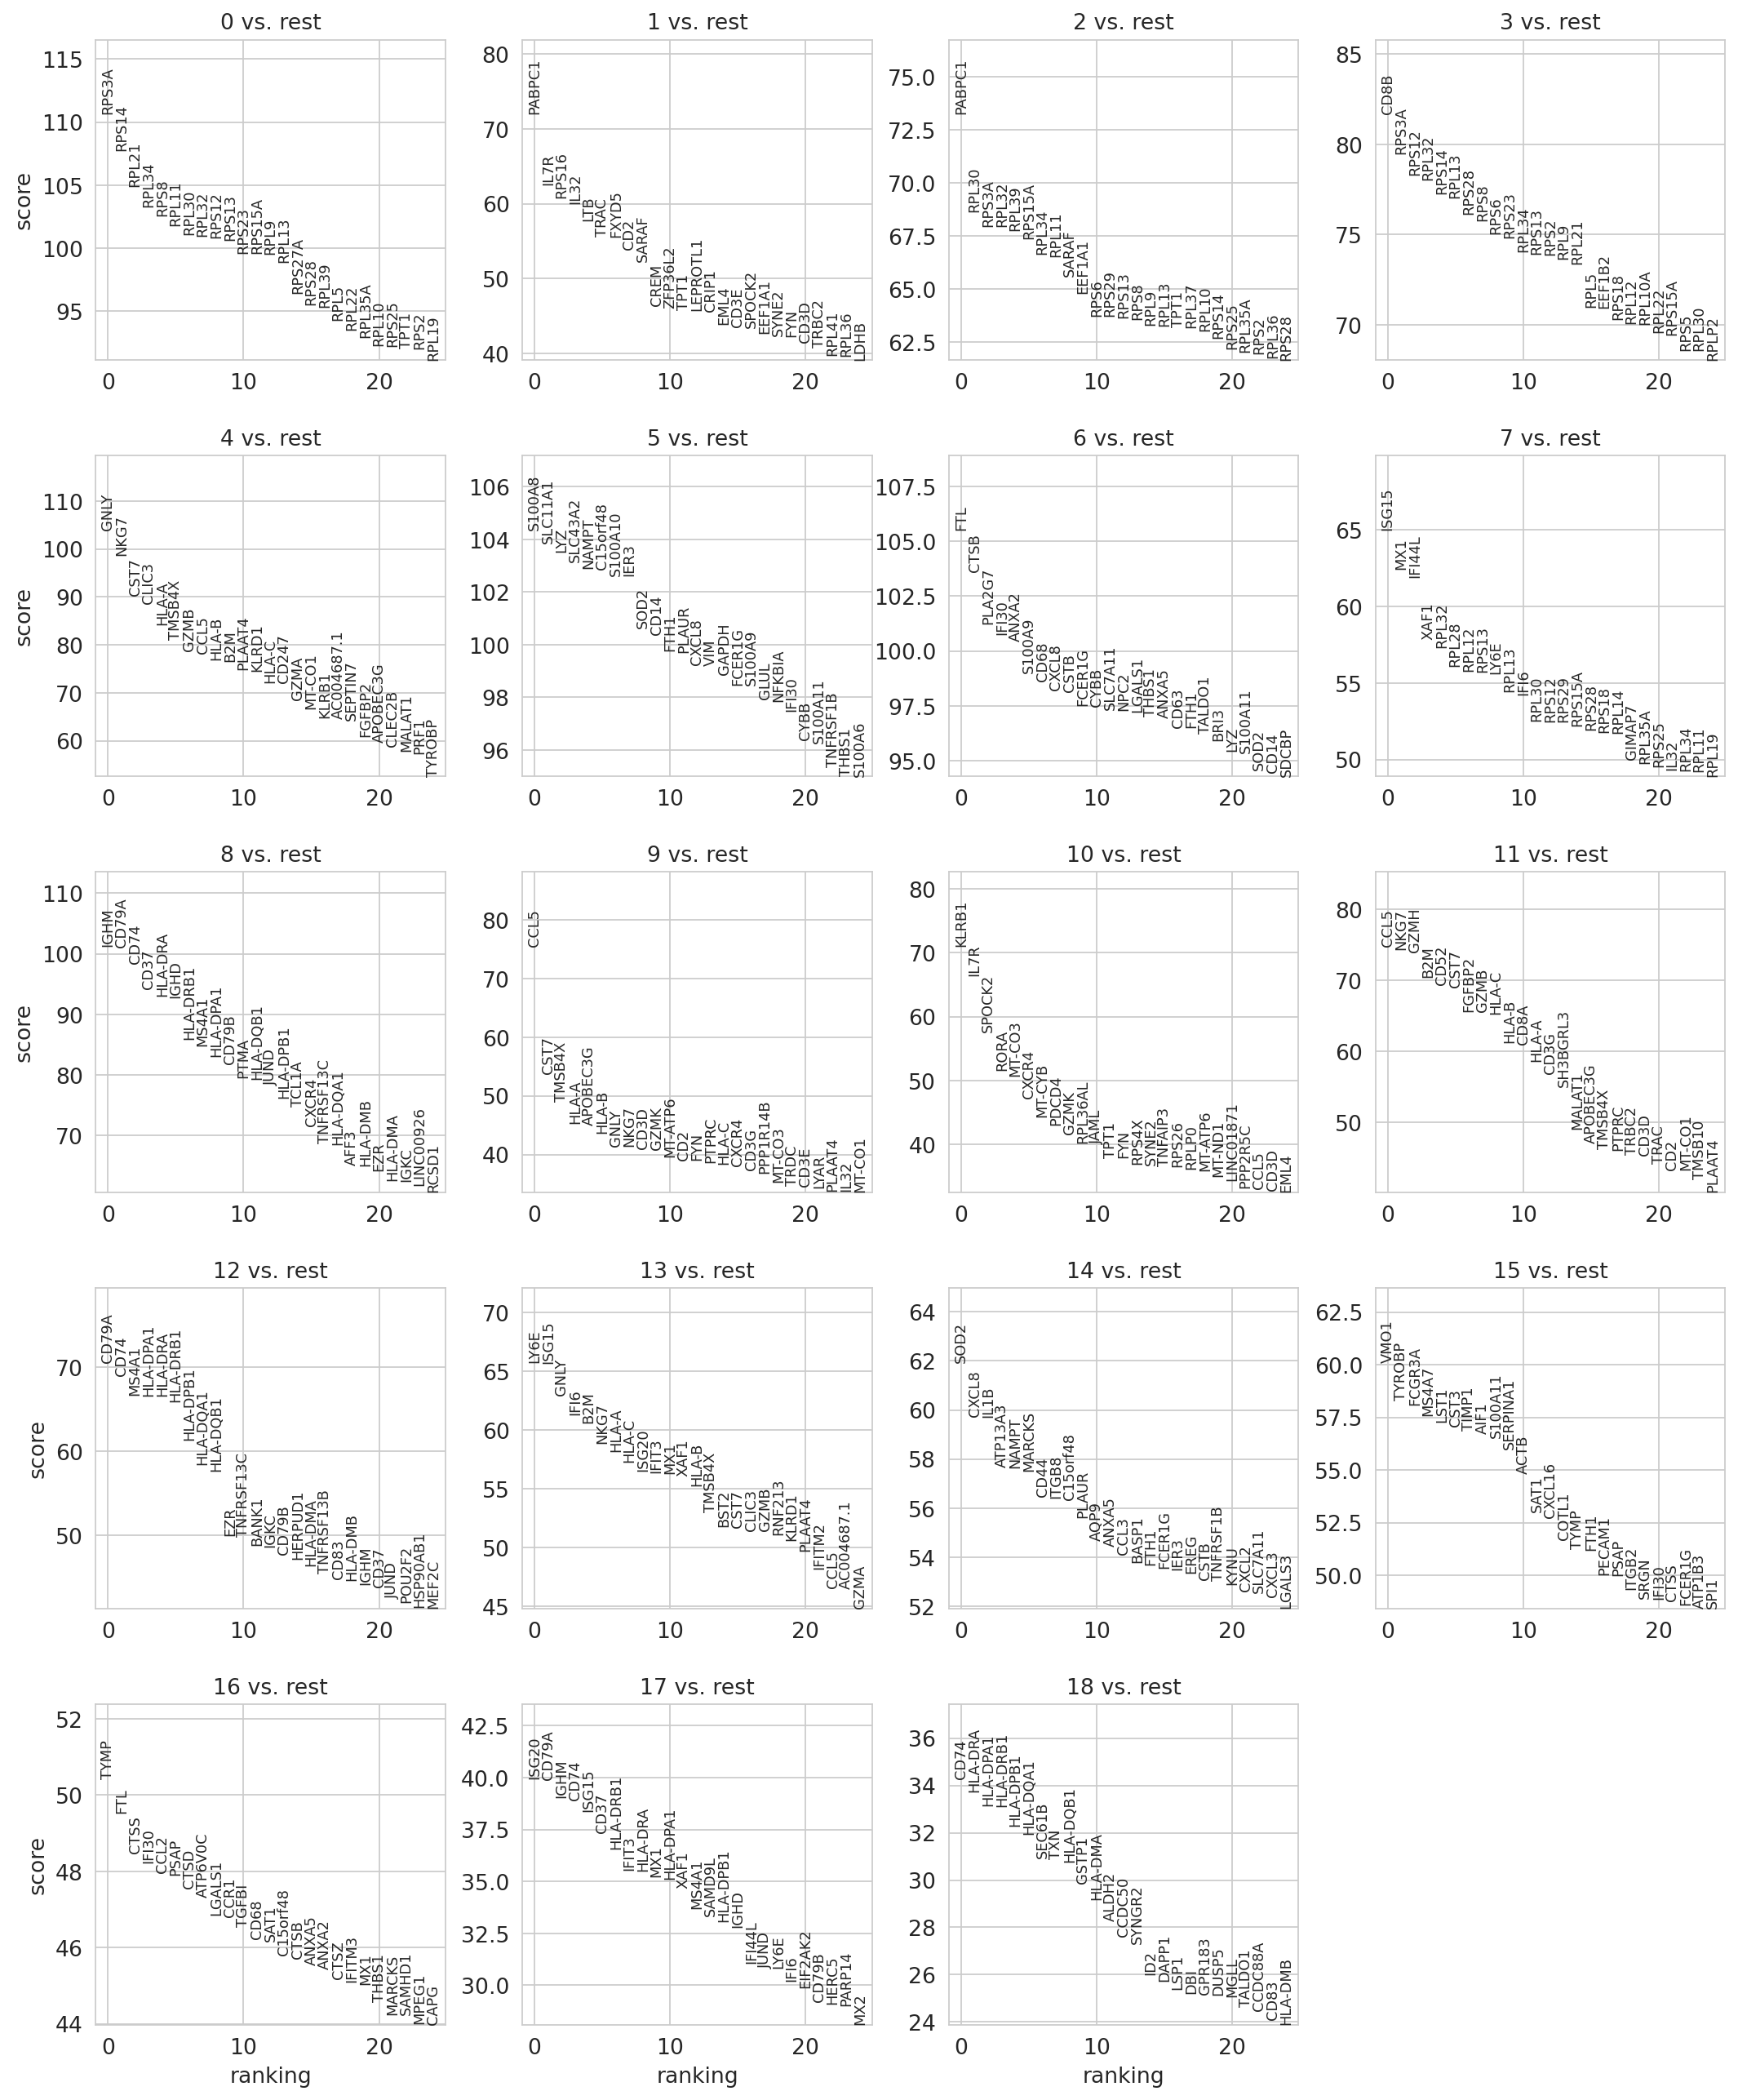

In [19]:
sc.tl.rank_genes_groups(adata_new, "leiden_1.0", method="wilcoxon",key_added='groups_genes_leiden_1')
sc.pl.rank_genes_groups(adata_new, n_genes=25, sharey=False,key='groups_genes_leiden_1')

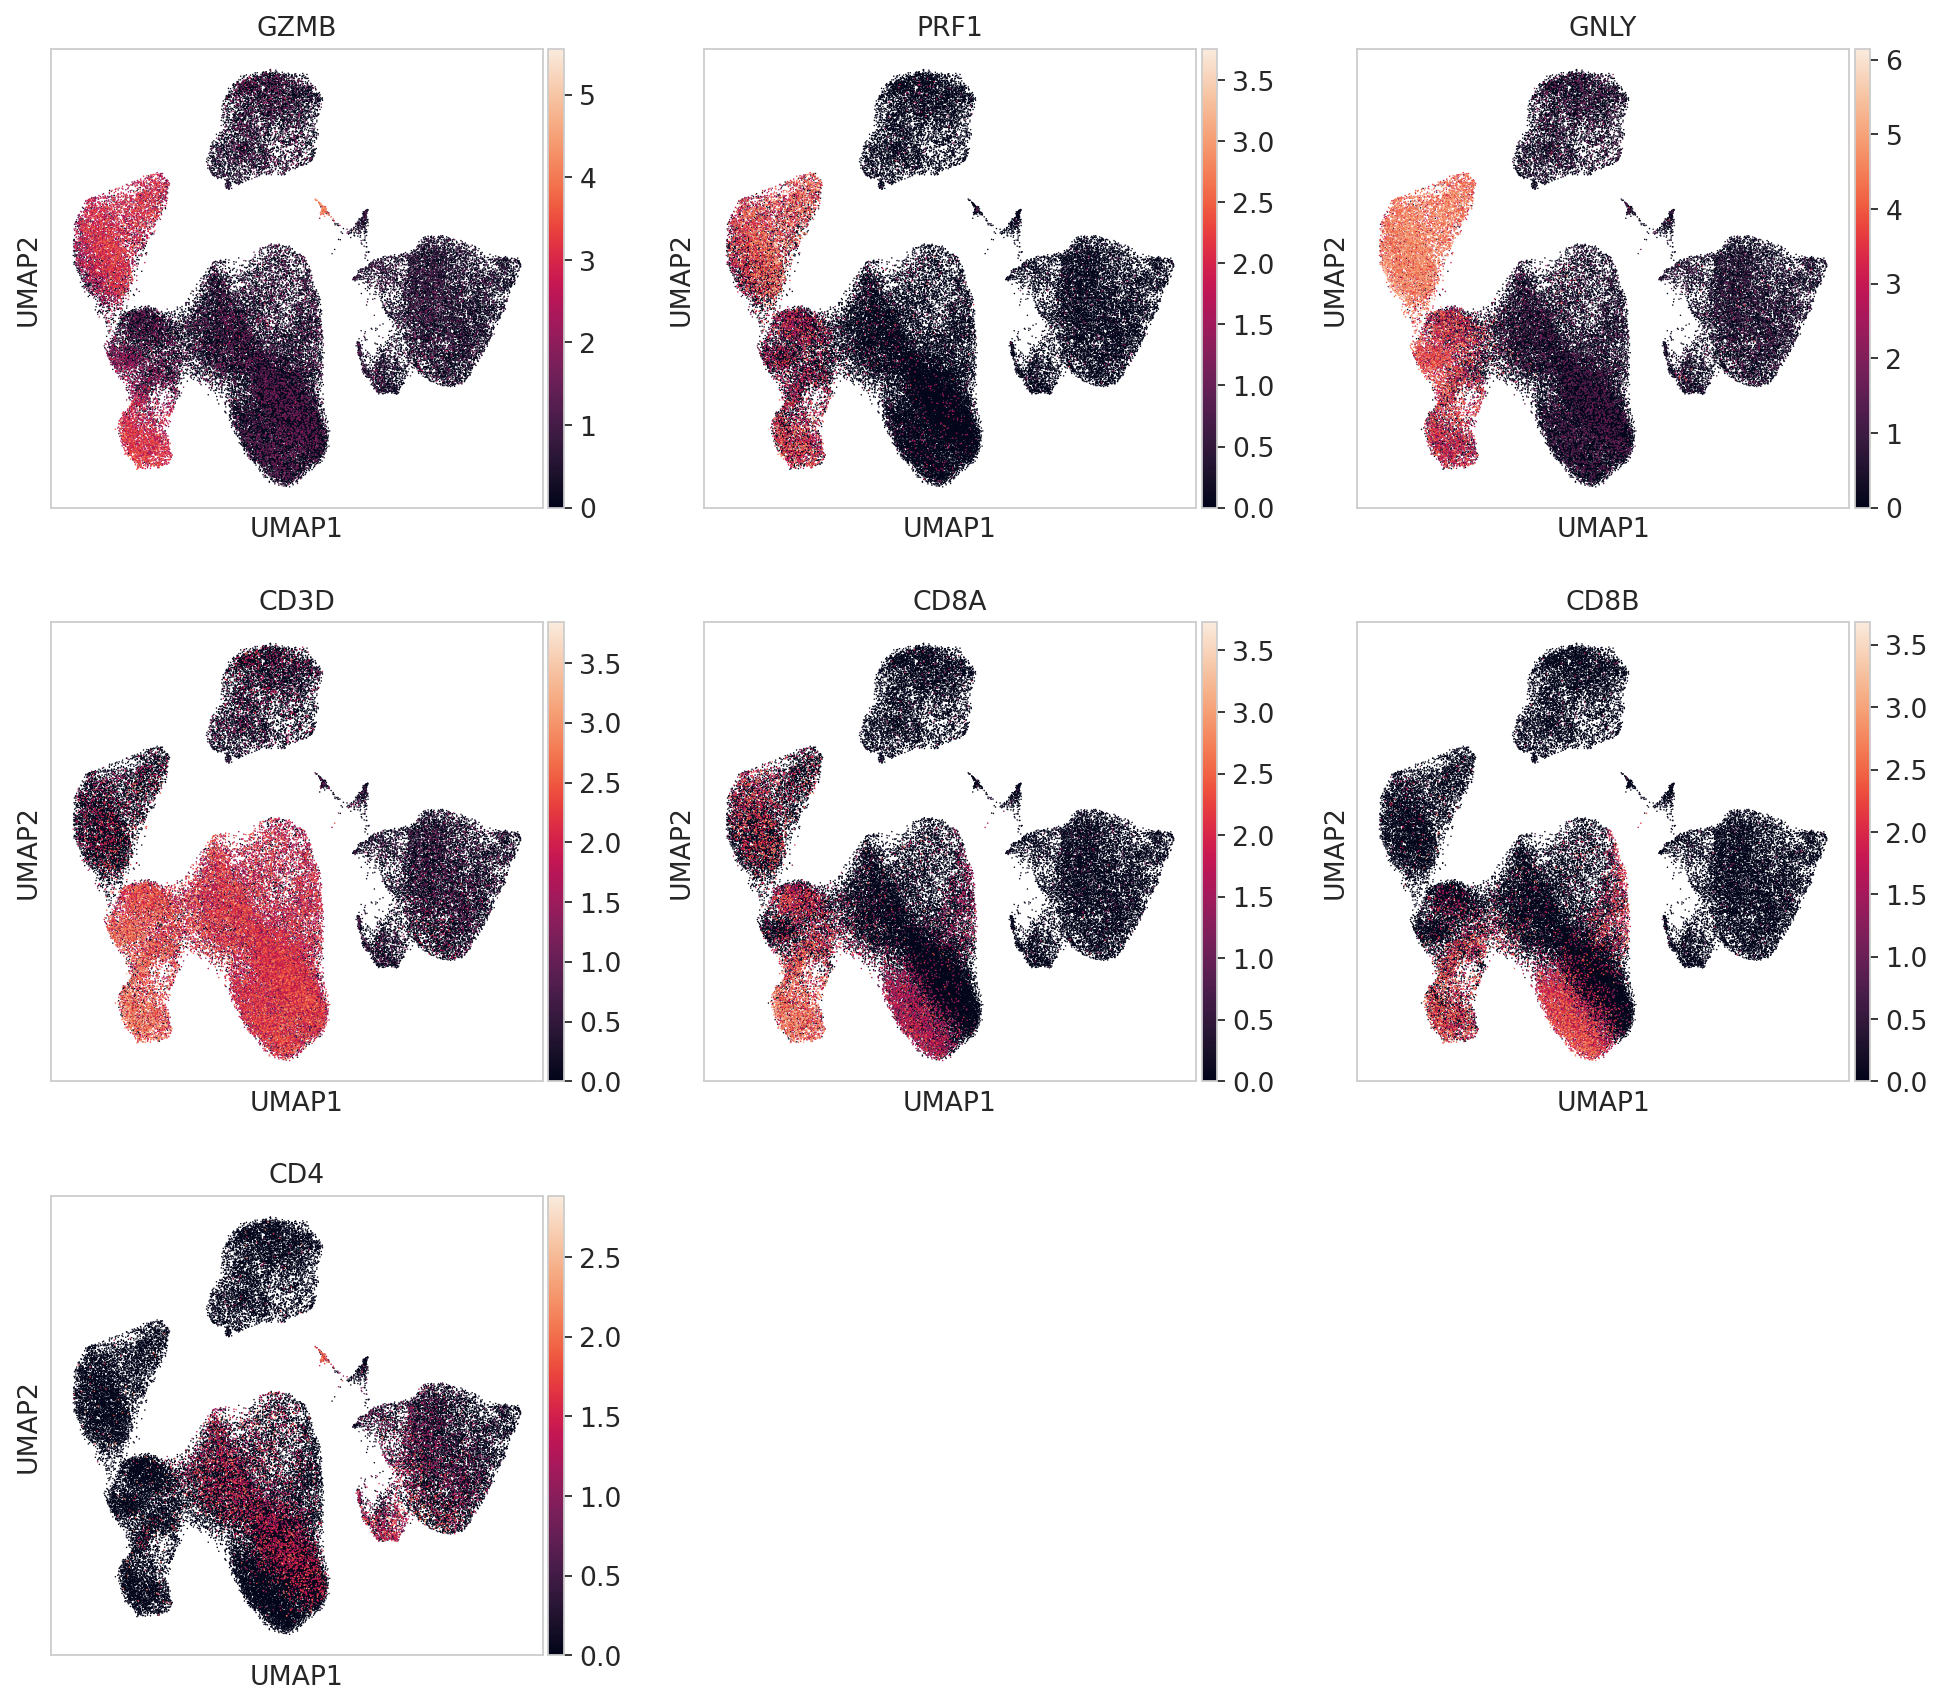

In [20]:
sc.pl.umap(adata_new, color= ['GZMB', 'PRF1', 'GNLY','CD3D','CD8A','CD8B','CD4'],ncols=3)

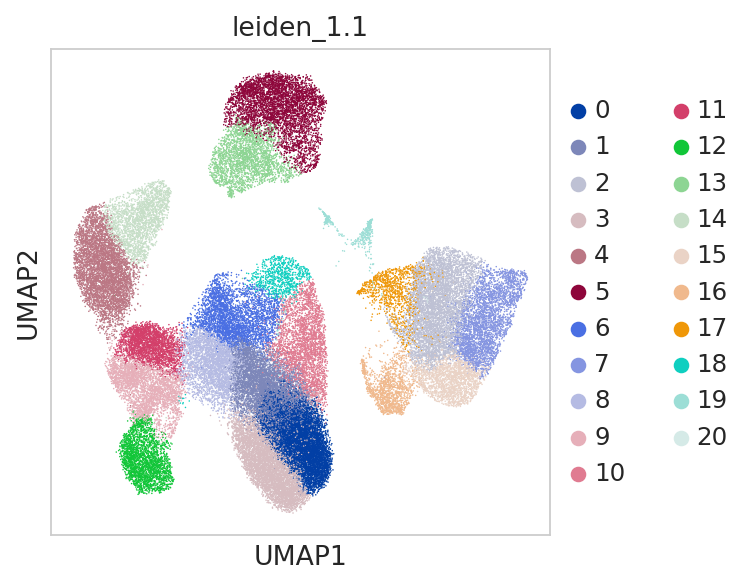

In [21]:
sc.pl.umap(adata_new, color=["leiden_1.1"])

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_1.1']`
categories: 0, 1, 2, etc.
var_group_labels: CD14 Monocytes, FCGR3A Monocytes, DCs, etc.


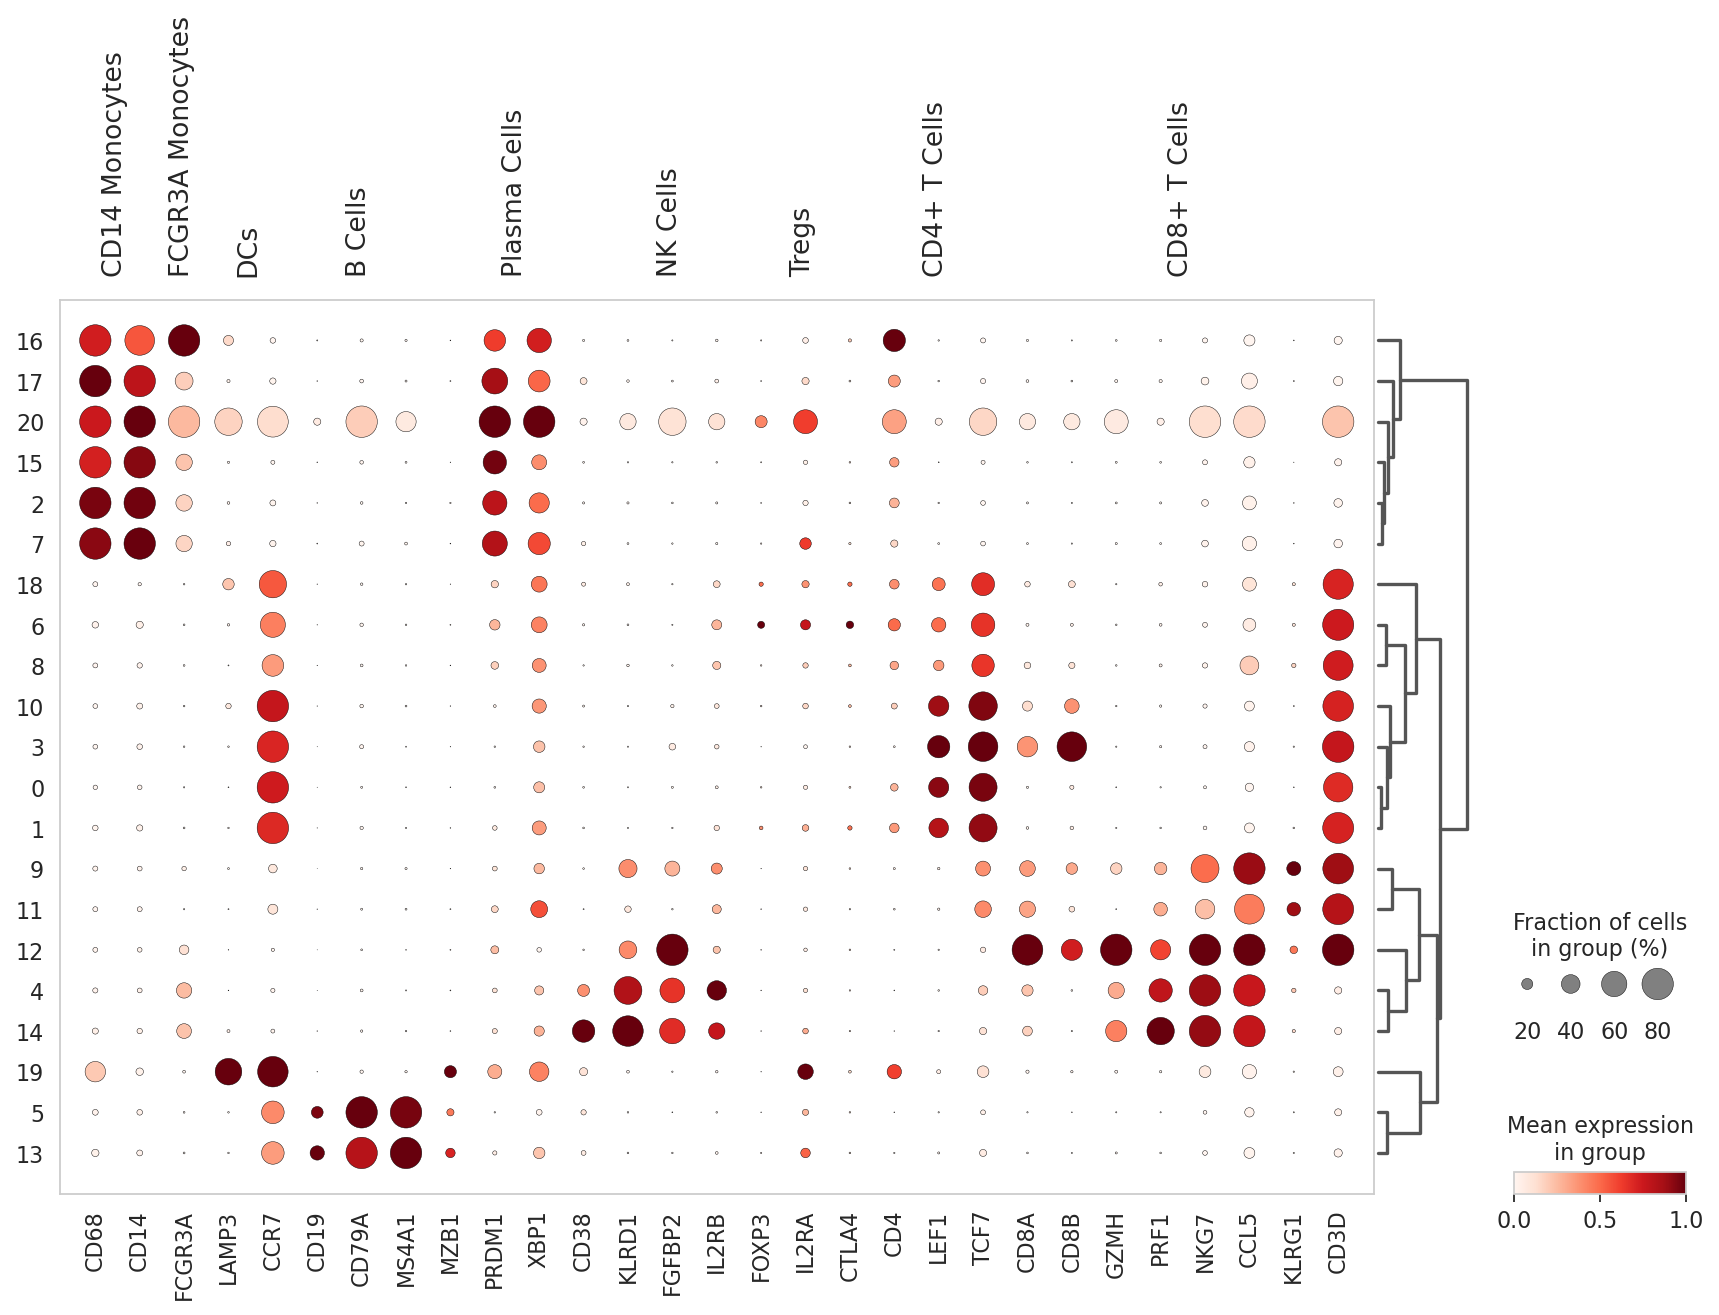

In [22]:
# Define a dictionary of key marker genes for major immune cell types
# Each cell type maps to a list of canonical markers used for identification
gene_dict = {
    'CD14 Monocytes': ['CD68', 'CD14'],
    'FCGR3A Monocytes': ['FCGR3A'],
    'DCs': ['LAMP3', 'CCR7'],
    'B Cells': ['CD19', 'CD79A', 'MS4A1'],
    'Plasma Cells': ['MZB1', 'PRDM1', 'XBP1', 'CD38'],
    'NK Cells': ['KLRD1', 'FGFBP2', 'IL2RB'],
    'Tregs': ['FOXP3', 'IL2RA', 'CTLA4'],
    'CD4+ T Cells': ['CD4', 'LEF1', 'TCF7'],
    'CD8+ T Cells': ['CD8A', 'CD8B', 'GZMH', 'PRF1', 'NKG7', 'CCL5', 'KLRG1', 'CD3D'],
}

# Generate a dot plot of gene expression across clusters defined by Leiden clustering at resolution 1.1
sc.pl.dotplot(
    adata_new,
    gene_dict,                        # Dictionary of marker genes grouped by cell type
    groupby="leiden_1.1",             # Clustering to group cells by
    dot_min=0,                        # Minimum dot size (helps with visibility of low expression)
    dot_max=0.8,                      # Maximum dot size to prevent overlapping
    dendrogram=True,                  # Add hierarchical clustering of groups to highlight similarity
    standard_scale='var'              # Scale expression per gene for comparability
)


In [23]:
# Define a mapping from Leiden clusters (at resolution 1.1) to broad immune cell types
# These labels are based on known marker genes and dot plot expression profiles
broad_cluster_names = {
    "0":  "CD4+ T Cells",
    "1":  "CD4+ T Cells",
    "2":  "CD14+ Monocytes",
    "3":  "CD8+ Naive T Cells",
    "4":  "NK Cells",
    "5":  "B Cells",
    "6":  "CD4+ T Cells",
    "7":  "CD14+ Monocytes",
    "8":  "CD4+ T Cells",
    "9":  "CD8+ Effector T Cells",
    "10": "CD8+ Naive T Cells",
    "11": "CD8+ Effector T Cells",
    "12": "CD8+ Effector T Cells",
    "13": "B Cells",
    "14": "NK Cells",
    "15": "CD14+ Monocytes",
    "16": "CD16+ Monocytes",
    "17": "CD14+ Monocytes",
    "18": "CD4+ T Cells",
    "19": "Dendritic Cells",
    "20": "CD14+ Monocytes"
}

# Create a new column in .obs that maps Leiden clusters to annotated broad cell types
adata_new.obs['Annotations_broad'] = adata_new.obs['leiden_1.1'].map(broad_cluster_names)


In [24]:

manual_order = ['B Cells', 
                'CD14+ Monocytes', 
                'CD16+ Monocytes', 
                'Dendritic Cells', 
                'CD8+ Effector T Cells', 
                'CD8+ Naive T Cells', 
                'CD4+ T Cells', 
                'NK Cells']  

adata_new.obs['Annotations_broad'] = pd.Categorical(adata_new.obs['Annotations_broad'], categories=manual_order, ordered=True)


In [25]:
celltype_color_dict = {
    'B Cells': '#8dd3c7',
    'CD14+ Monocytes': '#74c476',
    'CD16+ Monocytes': '#bebada',
    'Dendritic Cells': '#fb8072',
    'CD8+ Effector T Cells': '#80b1d3',
    'CD8+ Naive T Cells': '#fdb462',
    'CD4+ T Cells': '#b3de69',
    'NK Cells': '#fccde5',
    'Plasma Cells': '#ae017e'
}


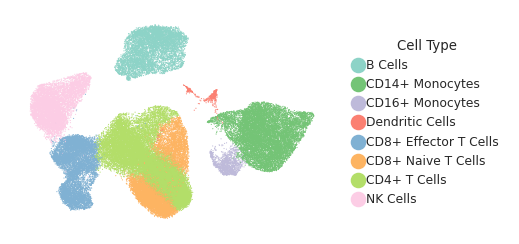

In [26]:
# Set Scanpy figure parameters: small font for compact layout
sc.set_figure_params(fontsize=6)

# Optional: define a fallback color palette (not used here since you provide `celltype_color_dict`)
palette_cust = ['#8dd3c7', '#74c476', '#bebada', '#fb8072', '#80b1d3',
                '#fdb462', '#b3de69', '#fccde5', '#ae017e', '#bc80bd']

# Initialize a compact figure for UMAP (ideal for figure panels)
fig, ax = plt.subplots(figsize=(2.5, 1.75))

# Plot UMAP embedding colored by broad annotations (cell types)
sc.pl.umap(
    adata_new,
    color=["Annotations_broad"],     # Column in .obs with cell type labels
    ncols=1,                         # Only one plot per figure
    palette=celltype_color_dict,     # Custom color dictionary for consistent cell type colors
    title='',                        # Remove title for minimal layout
    ax=ax,                           # Use pre-defined axis
    show=False,                      # Delay showing to customize layout
    size=1,                          # Dot size (adjust for your density)
    frameon=False                    # No border around UMAP plot
)

# Extract legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Add custom legend outside the plot
legend = ax.legend(
    handles,
    labels,
    title='Cell Type',               # Title of the legend
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),      # Position legend just outside plot
    frameon=False                    # Remove legend box
)

# Optional: bold legend title if desired
# legend.get_title().set_fontproperties(fm.FontProperties(weight='bold'))

# Save figure in high-resolution PDF format
plt.savefig(
    'Final_Notebooks/Figures/3_controls/UMAP_3_controls.pdf',
    bbox_inches='tight',             # Remove excess white space
    dpi=300                          # High-resolution output
)

# Display the finalized figure
plt.show(fig)


In [27]:
manual_order = ['Control', 
                'BTP2', 
                'CM4620']  

adata_new.obs['Condition'] = pd.Categorical(adata_new.obs['Condition'], categories=manual_order, ordered=True)


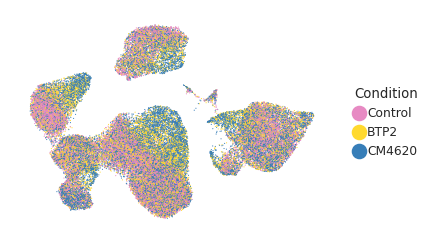

In [28]:
# Define a custom color palette for the experimental conditions
# Ensure the number of colors matches the number of unique conditions in adata_new.obs['Condition']
palette_cust = ['#e78ac3', '#ffd92f', '#377eb8', '#7570b3', '#e41a1c', '#4daf4a']

# Set global figure parameters for Scanpy plots
# fontsize=6 is ideal for compact figures; frameon=False removes default axes borders
sc.set_figure_params(fontsize=6, frameon=False)

# Create a compact figure for panel-style layout
fig, ax = plt.subplots(figsize=(2.5, 1.75))

# Plot the UMAP embedding, coloring cells by experimental condition
sc.pl.umap(
    adata_new,
    color=['Condition'],          # Metadata column to color by
    ncols=1,                      # Single panel
    title='',                     # No title for clean layout
    palette=palette_cust,         # Custom color palette
    ax=ax,                        # Use the predefined axis
    show=False,                   # Delay rendering for customization
    size=1,                       # Dot size (adjustable based on density)
    frameon=False                 # No border around the plot
)

# Extract legend handles and labels from the current axis
handles, labels = ax.get_legend_handles_labels()

# Customize and position the legend outside the plot area
legend = ax.legend(
    handles, 
    labels, 
    title='Condition',            # Title above legend entries
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),   # Place legend just outside the right edge
    frameon=False                 # No border around the legend
)

# Optional: make the legend title bold
# legend.get_title().set_fontproperties(fm.FontProperties(weight='bold'))

# Save the figure as a high-resolution PDF
plt.savefig(
    'Final_Notebooks/Figures/3_controls/condition_3_control.pdf',
    bbox_inches='tight',          # Trim whitespace
    dpi=300                       # High-resolution output for publication
)

# Show the plot
plt.show(fig)


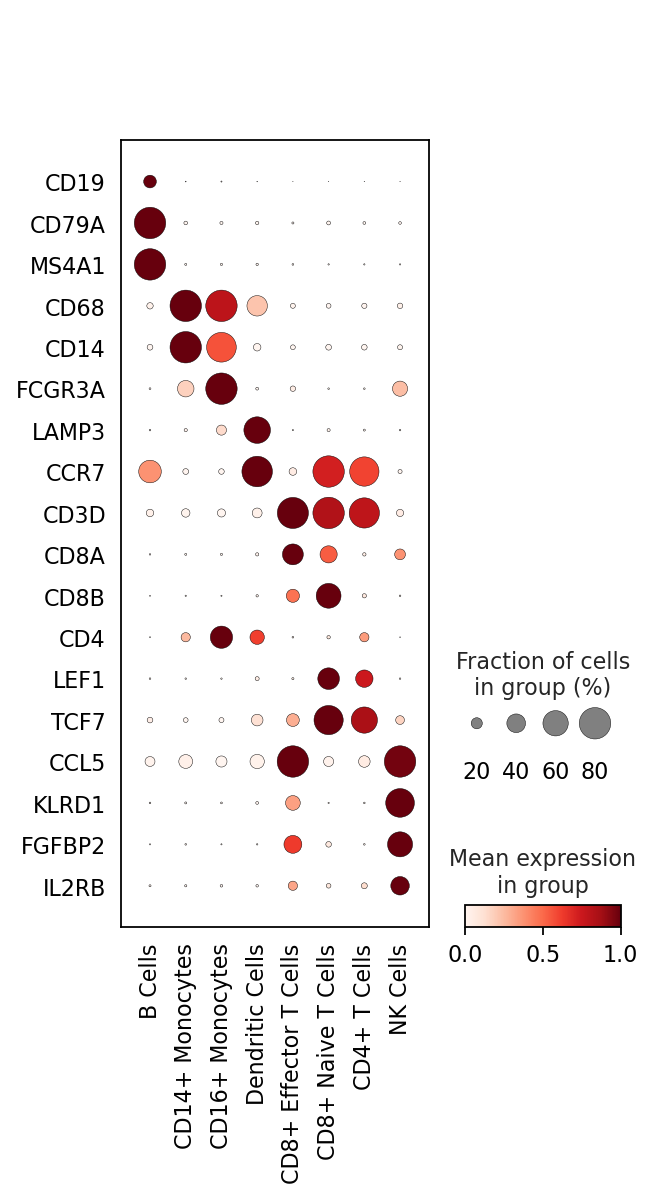

In [29]:
# Define a curated list of marker genes for major immune cell types
genes = [
    'CD19', 'CD79A', 'MS4A1',            # B Cells
    'CD68', 'CD14', 'FCGR3A',            # Monocytes (CD14+ and FCGR3A+ subsets)
    'LAMP3', 'CCR7',                     # Dendritic Cells
    'CD3D', 'CD8A', 'CD8B',              # CD8+ T Cells
    'CD4', 'LEF1', 'TCF7',               # CD4+ T Cells
    'CCL5',                              # Effector T Cell marker
    'KLRD1', 'FGFBP2', 'IL2RB'           # NK Cells
]

# Set global plotting parameters for Scanpy (clean look, larger text)
sc.set_figure_params(fontsize=12, frameon=False)

# Initialize the figure with a taller layout (genes on y-axis, cell types on x-axis)
fig, ax = plt.subplots(figsize=(4, 7.5))

# Generate a dotplot showing expression of selected marker genes across broad cell types
sc.pl.dotplot(
    adata_new,
    genes,
    groupby="Annotations_broad",        # Grouping based on annotated cell types
    dot_min=0,                          # Minimum dot size
    dot_max=0.8,                        # Maximum dot size (prevents overcrowding)
    dendrogram=False,                   # Disable dendrogram for a clean static order
    standard_scale='var',               # Normalize each gene across cell types
    ax=ax,                              # Pass the custom figure axis
    swap_axes=True,                     # Flip axes: genes on Y, cell types on X
    show=False                          # Delay rendering to save and customize
)

# Save the dotplot as a high-resolution PDF
plt.savefig(
    'Final_Notebooks/Figures/3_controls/dotplot_3_control_slim_text.pdf',
    bbox_inches='tight',                # Remove extra whitespace
    dpi=300                             # Publication-quality resolution
)

# Display the figure
plt.show(fig)


In [30]:
#Save h5ad object
adata_new.write("Final_Notebooks/Final_Objects/Control_analysis/PBMC_Clustered_Annotated.h5ad")

In [31]:
#load h5ad object
adata_new = sc.read_h5ad("Final_Notebooks/Final_Objects/Control_analysis/PBMC_Clustered_Annotated.h5ad")
adata_new

AnnData object with n_obs × n_vars = 64596 × 1575
    obs: 'ExperimentID', 'ConditionID', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'Donor', 'Condition', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'predicted_doublet_0.2', 'predicted_doublet_0.25', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'leiden_1.1', 'Annotations_broad'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    un

ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/tmp/ipykernel_2978153/2903917122.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_genes['-log10_pvals_adj'] = -np.log10(significant_genes['pvals_adj'])


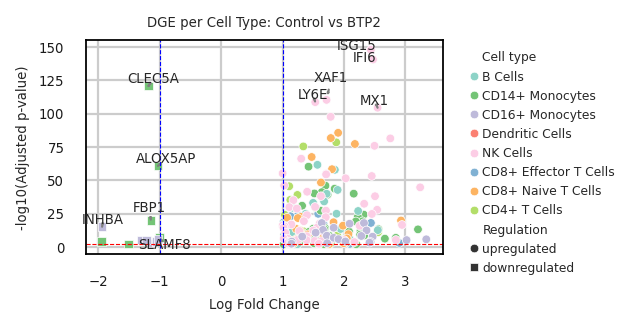

ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes


/home/as3562/miniconda3/envs/PBMC_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


/tmp/ipykernel_2978153/2903917122.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_genes['-log10_pvals_adj'] = -np.log10(significant_genes['pvals_adj'])


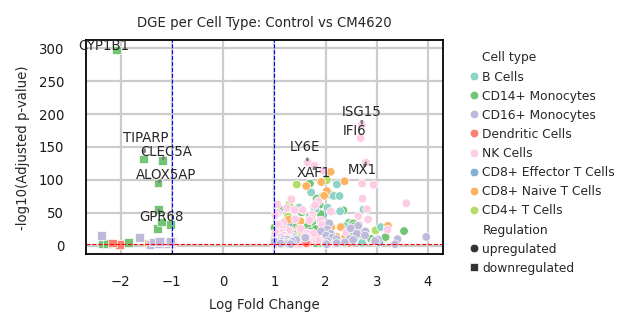

In [32]:
from adjustText import adjust_text

# Set global plot aesthetics
sns.set(style="white")
sc.set_figure_params(fontsize=6, frameon=False)

def differential_expression(adata, condition1, condition2, logfc_threshold=1.0, pval_adj_threshold=0.01):
    """
    Perform differential expression analysis between two conditions across each annotated broad cell type.
    Generates volcano-style scatterplots and exports CSVs of significant genes.
    """
    differential_expression_results = []

    # Define custom colors for each broad cell type
    cell_type_colors = {
        'B Cells': '#8dd3c7',
        'CD14+ Monocytes': '#74c476',
        'CD16+ Monocytes': '#bebada',
        'Dendritic Cells': '#fb8072',
        'CD8+ Effector T Cells': '#80b1d3',
        'CD8+ Naive T Cells': '#fdb462',
        'CD4+ T Cells': '#b3de69',
        'NK Cells': '#fccde5',
    }

    # Desired order of cell types in the legend
    cell_type_order = [
        'B Cells',
        'CD14+ Monocytes',
        'CD16+ Monocytes',
        'Dendritic Cells',
        'NK Cells',
        'CD8+ Effector T Cells',
        'CD8+ Naive T Cells',
        'CD4+ T Cells',
    ]

    # Define shape mappings for up/down-regulation
    regulation_shapes = {
        'upregulated': 'o',
        'downregulated': 's'
    }

    # Loop over each cell type and perform DE
    for cell_type in adata.obs['Annotations_broad'].unique():
        adata_sub = adata[adata.obs['Annotations_broad'] == cell_type]
        adata_sub = adata_sub[adata_sub.obs['Condition'].isin([condition1, condition2])]

        sc.tl.rank_genes_groups(
            adata_sub,
            groupby='Condition',
            groups=[condition1],
            reference=condition2,
            method='wilcoxon'
        )

        de_result = sc.get.rank_genes_groups_df(adata_sub, group=condition1)
        de_result['Cell type'] = cell_type
        differential_expression_results.append(de_result)

    # Combine all results
    de_results_combined = pd.concat(differential_expression_results, ignore_index=True)

    # Classify genes based on logFC and adjusted p-value thresholds
    de_results_combined['Regulation'] = 'not_significant'
    de_results_combined.loc[
        (de_results_combined['logfoldchanges'] >= logfc_threshold) &
        (de_results_combined['pvals_adj'] < pval_adj_threshold),
        'Regulation'
    ] = 'upregulated'
    de_results_combined.loc[
        (de_results_combined['logfoldchanges'] <= -logfc_threshold) &
        (de_results_combined['pvals_adj'] < pval_adj_threshold),
        'Regulation'
    ] = 'downregulated'

    # Filter significant genes
    significant_genes = de_results_combined[de_results_combined['Regulation'] != 'not_significant']
    significant_genes['-log10_pvals_adj'] = -np.log10(significant_genes['pvals_adj'])

    # Export significant gene table
    csv_filename = f"Final_Notebooks/Figures/3_controls/significant_genes_{condition1}_vs_{condition2}.csv"
    significant_genes.to_csv(csv_filename, index=False)

    # Plot: volcano-style scatter of DE genes across cell types
    plt.figure(figsize=(4, 2))
    sns.scatterplot(
        data=significant_genes,
        x='logfoldchanges',
        y='-log10_pvals_adj',
        hue='Cell type',
        hue_order=cell_type_order,
        style='Regulation',
        markers=regulation_shapes,
        palette=cell_type_colors,
        s=15
    )

    # Plot thresholds
    plt.axhline(y=-np.log10(pval_adj_threshold), color='red', linestyle='--', linewidth=0.5)
    plt.axvline(x=logfc_threshold, color='blue', linestyle='--', linewidth=0.5)
    plt.axvline(x=-logfc_threshold, color='blue', linestyle='--', linewidth=0.5)

    # Labels and layout
    plt.xlabel('Log Fold Change')
    plt.ylabel('-log10(Adjusted p-value)')
    plt.title(f'DGE per Cell Type: {condition2} vs {condition1}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

    # Highlight top genes with text labels
    texts = []
    for regulation in ['upregulated', 'downregulated']:
        top_genes = significant_genes[significant_genes['Regulation'] == regulation]\
                        .sort_values('-log10_pvals_adj', ascending=False)\
                        .head(5)
        for _, row in top_genes.iterrows():
            texts.append(plt.text(
                row['logfoldchanges'], row['-log10_pvals_adj'],
                row['names'], fontsize=6, ha='right'
            ))

    # Smart text adjustment
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=1))

    # Finalize and save
    plt.tight_layout()
    pdf_filename = f"Final_Notebooks/Figures/3_controls/significant_genes_{condition2}_vs_{condition1}_labeled.pdf"
    plt.savefig(pdf_filename, dpi=300, bbox_inches='tight')
    plt.show()

# Define pairs of conditions to compare
condition_pairs = [
    ('BTP2', 'Control'),
    ('CM4620', 'Control'),
    # Add more condition pairs as needed
]

# Run differential expression for each pair
for condition1, condition2 in condition_pairs:
    differential_expression(adata_new, condition1, condition2)


In [33]:
import gseapy as gp

def run_enrichr_for_celltypes(dge_results, gene_set_path, output_dir):
    """
    Perform Enrichr enrichment analysis using upregulated genes per cell type.

    Parameters:
    ----------
    dge_results : pd.DataFrame
        DataFrame containing DGE results with at least the following columns:
        'Cell type', 'names', 'logfoldchanges', 'pvals_adj'.

    gene_set_path : str
        Path to a GMT file containing the gene set collection (e.g., GO, KEGG, etc.).

    output_dir : str
        Directory where enrichment results will be saved.
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Filter for upregulated genes based on logFC and adjusted p-value thresholds
    filtered_results = dge_results[
        (dge_results['logfoldchanges'] > 1) &
        (dge_results['pvals_adj'] < 0.01)
    ]

    # Get unique cell types in the filtered set
    cell_types = filtered_results['Cell type'].unique()

    for cell_type in cell_types:
        # Subset genes for this cell type
        cell_type_data = filtered_results[filtered_results['Cell type'] == cell_type]
        upregulated_genes = cell_type_data['names'].dropna().tolist()

        if not upregulated_genes:
            print(f"[INFO] No upregulated genes found for cell type: {cell_type}")
            continue

        print(f"[RUNNING] Enrichr for {cell_type} with {len(upregulated_genes)} genes...")

        # Run Enrichr analysis
        try:
            enrichr_results = gp.enrichr(
                gene_list=upregulated_genes,
                gene_sets=gene_set_path,
                organism='Human',
                outdir=os.path.join(output_dir, f"{cell_type.replace(' ', '_')}_Enrichr"),
                cutoff=0.5  # Can adjust based on desired stringency
            )
            print(f"[DONE] Enrichr analysis complete for: {cell_type}")
        except Exception as e:
            print(f"[ERROR] Enrichr failed for {cell_type}: {e}")

# -------------------------------
# CONFIGURATION
# -------------------------------

# Output directory for results
output_dir = "Final_Notebooks/Enrichr_Results/CM4620_vs_Control/"

# Load DGE results from CSV (should match the same format generated in your volcano plot script)
dge_results = pd.read_csv("Final_Notebooks/Figures/3_controls/significant_genes_CM4620_vs_Control.csv")

# Path to a local gene set file (GMT format, e.g., GO:BP)
gene_set_path = "Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt"

# Run Enrichr analysis
run_enrichr_for_celltypes(dge_results, gene_set_path, output_dir)


[RUNNING] Enrichr for CD4+ T Cells with 23 genes...
[DONE] Enrichr analysis complete for: CD4+ T Cells
[RUNNING] Enrichr for CD8+ Effector T Cells with 23 genes...
[DONE] Enrichr analysis complete for: CD8+ Effector T Cells
[RUNNING] Enrichr for CD14+ Monocytes with 60 genes...
[DONE] Enrichr analysis complete for: CD14+ Monocytes
[RUNNING] Enrichr for B Cells with 39 genes...
[DONE] Enrichr analysis complete for: B Cells
[RUNNING] Enrichr for CD8+ Naive T Cells with 32 genes...
[DONE] Enrichr analysis complete for: CD8+ Naive T Cells
[RUNNING] Enrichr for NK Cells with 68 genes...
[DONE] Enrichr analysis complete for: NK Cells
[RUNNING] Enrichr for Dendritic Cells with 2 genes...
[DONE] Enrichr analysis complete for: Dendritic Cells
[RUNNING] Enrichr for CD16+ Monocytes with 40 genes...
[DONE] Enrichr analysis complete for: CD16+ Monocytes


In [34]:
import gseapy as gp

def run_enrichr_for_celltypes(dge_results, gene_set_path, output_dir):
    """
    Perform Enrichr enrichment analysis using upregulated genes per cell type.

    Parameters:
    ----------
    dge_results : pd.DataFrame
        DataFrame containing DGE results with at least the following columns:
        'Cell type', 'names', 'logfoldchanges', 'pvals_adj'.

    gene_set_path : str
        Path to a GMT file containing the gene set collection (e.g., GO, KEGG, etc.).

    output_dir : str
        Directory where enrichment results will be saved.
    """

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Filter for upregulated genes based on logFC and adjusted p-value thresholds
    filtered_results = dge_results[
        (dge_results['logfoldchanges'] > 1) &
        (dge_results['pvals_adj'] < 0.01)
    ]

    # Get unique cell types in the filtered set
    cell_types = filtered_results['Cell type'].unique()

    for cell_type in cell_types:
        # Subset genes for this cell type
        cell_type_data = filtered_results[filtered_results['Cell type'] == cell_type]
        upregulated_genes = cell_type_data['names'].dropna().tolist()

        if not upregulated_genes:
            print(f"[INFO] No upregulated genes found for cell type: {cell_type}")
            continue

        print(f"[RUNNING] Enrichr for {cell_type} with {len(upregulated_genes)} genes...")

        # Run Enrichr analysis
        try:
            enrichr_results = gp.enrichr(
                gene_list=upregulated_genes,
                gene_sets=gene_set_path,
                organism='Human',
                outdir=os.path.join(output_dir, f"{cell_type.replace(' ', '_')}_Enrichr"),
                cutoff=0.5  # Can adjust based on desired stringency
            )
            print(f"[DONE] Enrichr analysis complete for: {cell_type}")
        except Exception as e:
            print(f"[ERROR] Enrichr failed for {cell_type}: {e}")

# -------------------------------
# CONFIGURATION
# -------------------------------

# Output directory for results
output_dir = "Final_Notebooks/Enrichr_Results/BTP2_vs_Control/"

# Load DGE results from CSV (should match the same format generated in your volcano plot script)
dge_results = pd.read_csv("Final_Notebooks/Figures/3_controls/significant_genes_BTP2_vs_Control.csv")

# Path to a local gene set file (GMT format, e.g., GO:BP)
gene_set_path = "Final_Notebooks/GSEA_files/c5.all.v2023.2.Hs.symbols.gmt"

# Run Enrichr analysis
run_enrichr_for_celltypes(dge_results, gene_set_path, output_dir)


[RUNNING] Enrichr for CD4+ T Cells with 15 genes...
[DONE] Enrichr analysis complete for: CD4+ T Cells
[RUNNING] Enrichr for CD8+ Effector T Cells with 15 genes...
[DONE] Enrichr analysis complete for: CD8+ Effector T Cells
[RUNNING] Enrichr for CD14+ Monocytes with 42 genes...
[DONE] Enrichr analysis complete for: CD14+ Monocytes
[RUNNING] Enrichr for B Cells with 23 genes...
[DONE] Enrichr analysis complete for: B Cells
[RUNNING] Enrichr for CD8+ Naive T Cells with 23 genes...
[DONE] Enrichr analysis complete for: CD8+ Naive T Cells
[RUNNING] Enrichr for NK Cells with 56 genes...
[DONE] Enrichr analysis complete for: NK Cells
[RUNNING] Enrichr for CD16+ Monocytes with 22 genes...
[DONE] Enrichr analysis complete for: CD16+ Monocytes


In [36]:
!pip list

Package                   Version
------------------------- --------------
adjustText                1.3.0
anndata                   0.10.9
anyio                     4.6.2.post1
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
array_api_compat          1.9.1
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     24.2.0
babel                     2.16.0
beautifulsoup4            4.12.3
bleach                    6.2.0
Brotli                    1.1.0
cached-property           1.5.2
certifi                   2024.8.30
cffi                      1.17.1
charset-normalizer        3.4.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.0
cycler                    0.12.1
debugpy                   1.8.8
decorator                 5.1.1
defusedxml                0.7.1
entrypoints               0.4
et_xmlfile                2.0.0
exceptiongroup            1.2.2
executing    